*Authors:* Ismael Mendoza, Andrii Torchylo, Thomas Sainrat

## Intro and setup

This notebook demonstrates how to use BTK to produce more advanced analysis plots on metrics produced from the output of running multiple deblenders simultaneously on the same simulations.

In [ ]:
%matplotlib inline

In [ ]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm

import btk
import multiprocessing as mp
from btk.plotting import CB_color_cycle

In [ ]:
# for nice looking plots
plt.rcParams.update({
    # fonts
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "text.latex.preamble": r"\usepackage{amsmath}",
    "mathtext.fontset": "cm",
    "font.size": 14,
    # colors
    "axes.prop_cycle": mpl.cycler(color=CB_color_cycle),
    # figure layout
    "figure.autolayout": True,
})

## Utilities

In [ ]:
def get_psf_size(survey: btk.survey.Survey) -> float:
    """Return the PSF size in pixels."""
    psf_size_arcsec =  survey.get_filter('r').psf_fwhm.to_value('arcsec')
    pixel_scale = survey.pixel_scale.to_value('arcsec')
    return psf_size_arcsec / pixel_scale

## Setup simulation

For all our examples in this notebook we will use the same simulation and generator. Our simulation we use the `DefaultSamplingFunction` which randomly samples galaxies from the given input catalog and places them a random distance at most `max_shift` from the center of the stamp. We use a `max_shift` of 3 arcseconds which makes blends more likely. 

We also limit each blend to having between 0 and 10 light sources (uniformly at random) and we limit ourselves to sources that have an `i`-band LSST magnitude between 18 and 27. The galaxies are parametric bulge+disk+AGN galaxies drawn from the input CATSIM catalog.

In [ ]:
max_n_sources = 10
min_n_sources = 0
stamp_size = 24.0
max_shift = 3.0 # shift from center is 3 arcsecs = 15 pixels, so blends are likely.
seed = 0

catalog = btk.catalog.CatsimCatalog.from_file('../data/input_catalog.fits')

sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_n_sources,
    min_number=min_n_sources,
    stamp_size=stamp_size,
    max_shift=max_shift,
    min_mag = 18,
    max_mag = 27,
    mag_name="i_ab", # cutting on i-band
    seed = seed
)

survey = btk.survey.get_surveys('LSST')

batch_size = 100

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    njobs=1,
    add_noise="background",
    seed=seed, # use same seed here
)

## Example blends

First, we generate some example blends and visualize to ensure our simulation looks like what we want.

In [ ]:
blend_batch = next(draw_generator)

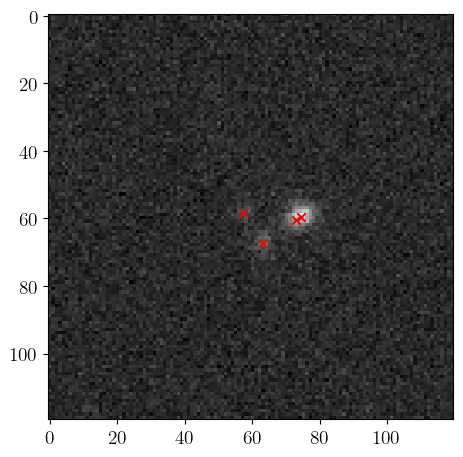

In [ ]:
import matplotlib.pyplot as plt

# plot a random blend in the batch, in the r-band
ii = np.random.randint(0, 100)
plt.imshow(blend_batch.blend_images[ii, 2, :, :], cmap="gray")

# plot centers
plt.scatter(blend_batch.catalog_list[ii]["x_peak"],
            blend_batch.catalog_list[ii]["y_peak"], c="r", marker="x")

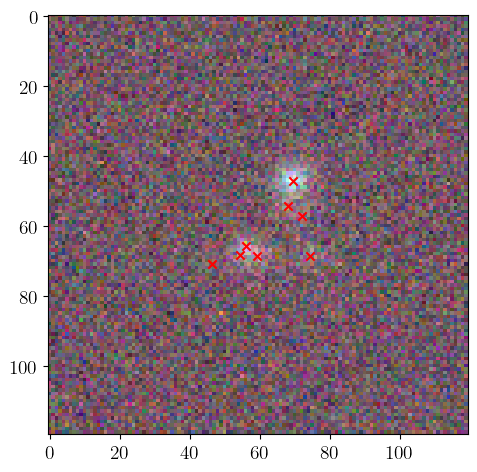

In [ ]:
# same but plot in rgb
from btk.plotting import get_rgb

fig, ax = plt.subplots(1,1,figsize=(5,5))

ii = np.random.randint(0, 100)
im = blend_batch.blend_images[ii]
bands = [1,2,3]
rgb = get_rgb(im[bands])
ax.imshow(rgb)
ax.scatter(blend_batch.catalog_list[ii]["x_peak"],
            blend_batch.catalog_list[ii]["y_peak"], c="r", marker="x")

## Efficiency matrices using Peak-finding and SEP 

For our first analysis plot, we will compare the efficiency matrices between the peak-finding algorithm in `scikit-image` and compare it with `SEP` (source extractor in python). We will run both algorithms targeting the `r`-band images.

We will accumulate the results over `1000` blends. 

In [ ]:
from surveycodex.utilities import mean_sky_level
from btk.deblend import SepSingleBand, PeakLocalMax

# sky level
sky_level = mean_sky_level(survey, survey.get_filter('r')).to_value('electron') # gain = 1

# use psf size as minimum distance between peaks (in pixels) for the peak-finding algorithm.
min_distance = int(get_psf_size(survey)) # needs to be an integer


# setup both deblenders
peak_finder = PeakLocalMax(max_n_sources=max_n_sources+10,
                           sky_level=sky_level,
                           threshold_scale=5,
                           min_distance=min_distance,
                           use_band=2 # r-band
                           )

# standard values for SEP that work well for blended galaxy scenes
thresh = 1.5
min_area = 5

sep = SepSingleBand(max_n_sources=max_n_sources+10, thresh=thresh, min_area=min_area, use_band=2)

Now we setup the default matcher in BTK, which uses the Hungarian algorithm for matching:

In [ ]:
from btk.match import PixelHungarianMatcher

# matcher
matcher = PixelHungarianMatcher(pixel_max_sep=min_distance
                                )

This is where we setup the metrics `Efficiency` object for the efficiency matrices, which comes from `btk.metrics.detection` module. We need to create one metric object per deblender that we want to evaluate. Next, we use the `draw_generator` to create a new `blend_batch` and run the deblenders on the corrrepsonding images. Finally, we run the efficiency matrix on the matched results. 

We accumulate and repeat this procedure 10 times to achieve 1000 images total analyzed.

In [ ]:
from btk.metrics.detection import Efficiency

# setup efficiency matrix metric
eff_matrix_peak= Efficiency(batch_size)
eff_matrix_sep = Efficiency(batch_size)

for ii in tqdm(range(10)):
    blend_batch = next(draw_generator)
    peak_batch = peak_finder(blend_batch)
    sep_batch = sep(blend_batch)
    matching_peak = matcher(blend_batch.catalog_list, peak_batch.catalog_list)
    matching_sep = matcher(blend_batch.catalog_list, sep_batch.catalog_list)
    eff_matrix_peak(matching_peak.tp, matching_peak.t, matching_peak.p)
    eff_matrix_sep(matching_sep.tp, matching_sep.t, matching_sep.p)

100%|██████████| 10/10 [01:02<00:00,  6.20s/it]


In [ ]:
# get efficiency matrices and normalize
mat1 = eff_matrix_peak.aggregate()
mat1 = mat1 / mat1.sum(axis=0)

mat2 = eff_matrix_sep.aggregate()
mat2 = mat2 / mat2.sum(axis=0)

Now we plot both efficiency matrices simultaneously (after normalizing them):

In [ ]:
mat1.shape, mat2.shape

((6, 11), (8, 11))

/Users/imendoza/miniconda3/envs/scarlet1/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/imendoza/miniconda3/envs/scarlet1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


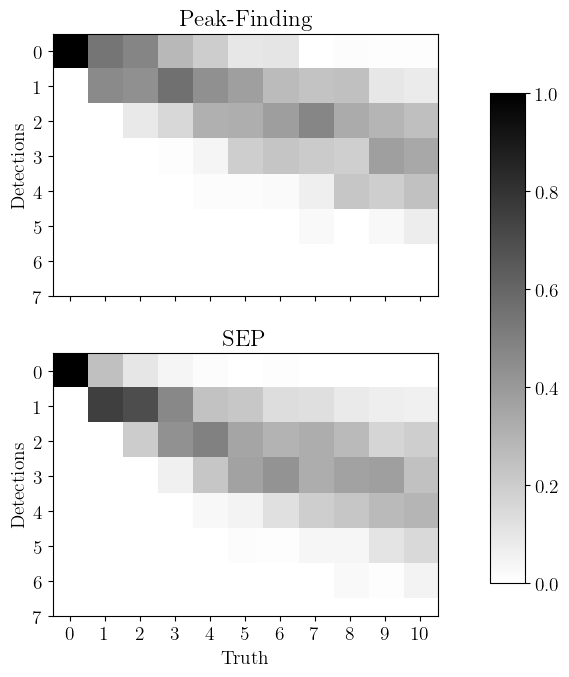

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7, 7))
ax1, ax2 = axes

# titles
ax1.set_title(r"\rm Peak-Finding")
ax2.set_title(r"\rm SEP")

# axes labels
ax1.set_ylabel(r"\rm Detections")
ax2.set_ylabel(r"\rm Detections")
ax2.set_xlabel(r"\rm Truth")

# cut at 6
_mat2 = mat2[:7, :]

# expand first matrix to make it to make it the same size as the second one (looks better)
_mat1 =  np.zeros_like(_mat2)
r, c  = mat1.shape
_mat1[:r, :c] = mat1[:, :]

# plot
im1 = ax1.imshow(_mat1, vmin=0, vmax=1, cmap='binary')
im2 = ax2.imshow(_mat2, vmin=0, vmax=1, cmap='binary')

# make colorbar
fig.subplots_adjust(right=1.1, hspace=0.3)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax)

ax1.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
ax2.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]);

In [ ]:
# save figure (if desired)
assert Path("figures").exists()
fig.savefig("figures/effmatrix.png", bbox_inches='tight', dpi=500)

/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_27048/1327449877.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig("figures/effmatrix.png", bbox_inches='tight', dpi=500)


## Reconstruction metrics histograms

In this next analysis plot, we compare the reconstructions of individual galaxies using SEP compared to that of the Scarlet deblender using a pair of histograms. We use all of the three reconstruction metrics implemented in BTK: mean-squared error (MSE), peak signal-to-noise-ratio (pSNR), and structure similarity index (SSIM). 

We again choose to use the `r`-band images for this comparison.

As before, we start by setting up the metrics and deblending algorithms first:

In [ ]:
from btk.metrics.reconstruction import MSE, PSNR, StructSim
from btk.match import PixelHungarianMatcher
from btk.deblend import SepSingleBand, Scarlet


metrics_sep = {'mse': MSE(batch_size),
               'psnr': PSNR(batch_size),
               'ssim': StructSim(batch_size)
               }

metrics_scarlet = {'mse': MSE(batch_size),
                   'psnr': PSNR(batch_size),
                   'ssim': StructSim(batch_size)
                   }

 # same as before
thresh = 1.5
min_area = 5

# use psf size as minimum distance between peaks (in pixels).
min_distance = int(get_psf_size(survey))
sep = SepSingleBand(max_n_sources=max_n_sources, thresh=thresh, use_band=2, min_area=min_area)
scarlet = Scarlet(max_n_sources)
matcher = PixelHungarianMatcher(min_distance)


Below we compute the reconstruction metrics on SEP detections that were matched to true galaxy centroids. Since Scarlet does not do detections, we pass in the `catalog_list` of the SEP deblender output as a `reference_catalog`. 

In [ ]:
njobs = 4 if mp.cpu_count() > 4 else mp.cpu_count() - 1


for ii in tqdm(range(10)):
    blend_batch = next(draw_generator)
    sep_batch = sep(blend_batch)
    scarlet_batch = scarlet(blend_batch, # this line takes a while
                            reference_catalogs=sep_batch.catalog_list,
                            njobs=njobs
                            )
    matching_sep = matcher(blend_batch.catalog_list, sep_batch.catalog_list)
    matching_scarlet = matcher(blend_batch.catalog_list, scarlet_batch.catalog_list)

    true_iso_images = blend_batch.isolated_images[:, :, 2] # pick 'r' band
    iso_images_sep = sep_batch.deblended_images[:, :, 0] # pick the only band which is the 'r' band
    iso_images_scarlet = scarlet_batch.deblended_images[:, :, 2] # pick 'r' band

    iso_images1 = matching_sep.match_true_arrays(true_iso_images)
    iso_images2 = matching_scarlet.match_true_arrays(true_iso_images)
    iso_images_sep = matching_sep.match_pred_arrays(iso_images_sep)
    iso_images_scarlet = matching_scarlet.match_pred_arrays(iso_images_scarlet)

    for metric in metrics_sep.values():
        metric(iso_images1, iso_images_sep)

    for metric in metrics_scarlet.values():
        metric(iso_images2, iso_images_scarlet)

100%|██████████| 10/10 [23:47<00:00, 142.72s/it]


Below we aggregate the computed metrics across all batches and sources. Every metric in BTK includes an attribute `all_data`, which is a dictionary containing the intermediate values used to compute the final metric. In the case of the reconstruction metrics, the intermediate value is the corresponding metric computed on a per light source basis, which is exactly what we want to use for our histogram. Given this, we simply concatenate all of the corresponding arrays.

In [ ]:
# join data from all batches into single array

# sep
all_sep = {'mse': np.array([]), 'psnr': np.array([]), 'ssim': np.array([])}
for metric_name, metric in metrics_sep.items():
    for mvalues in metric.all_data:
        all_sep[metric_name] = np.concatenate([all_sep[metric_name], mvalues[metric_name]])

# scarlet
all_scarlet = {'mse': np.array([]), 'psnr': np.array([]), 'ssim': np.array([])}
for metric_name, metric in metrics_scarlet.items():
    for mvalues in metric.all_data:
        all_scarlet[metric_name] = np.concatenate([all_scarlet[metric_name], mvalues[metric_name]])

Finally, we use the aggregated arrays for each metric to plot some histograms:

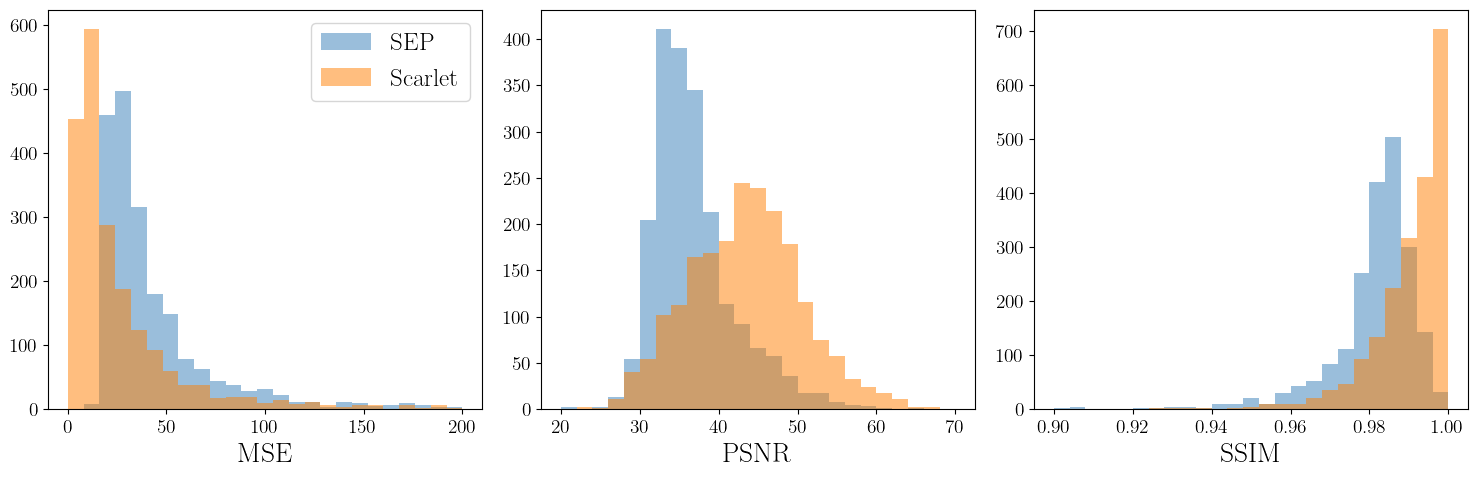

In [ ]:
# plot histograms of each metric for both deblenders
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ranges = [(0, 200), (20, 70), (0.9, 1.0)]
latex_metric_names = [r'\rm MSE', r'\rm PSNR', r'\rm SSIM']
for ii, metric_name in enumerate(['mse', 'psnr', 'ssim']):
    ax = axes[ii]
    _, bins, _ = ax.hist(all_sep[metric_name], bins=25, alpha=0.5, label=r'\rm SEP',
                         color='C0', histtype='stepfilled',  range=ranges[ii])
    ax.hist(all_scarlet[metric_name], bins=bins, alpha=0.5, label=r'\rm Scarlet',
            color='C1', histtype='stepfilled',  range=ranges[ii])
    ax.set_xlabel(latex_metric_names[ii], fontsize=20)
    if ii == 0:
        ax.legend(prop={'size':18})

In [ ]:
# save figure (if desired)
assert Path("figures").exists()
fig.savefig("figures/reconstruction.png", bbox_inches='tight', dpi=500)

## Recall curves

For this analysis plot we compare the detection peformance of SEP and the `peak_local_max` algorithm in `scikit-image` by plotting a recall curve as a function of SNR (using the `r`-band images).

In what follows, we setup our deblenders, the matcher that we will use, and obtain the survey sky level in the r-band which we will need for SNR computations.

In [ ]:
from btk.deblend import SepSingleBand, PeakLocalMax
from surveycodex.utilities import mean_sky_level


# sky level
sky_level = mean_sky_level(survey, survey.get_filter('r')).to_value('electron') # gain = 1


# use psf size as minimum distance between peaks (in pixels).
min_distance = int(get_psf_size(survey)) # needs to be an integer

# setup both deblenders (same as previous experiments)
peak_finder = PeakLocalMax(max_n_sources=max_n_sources+10,
                           sky_level=sky_level,
                           threshold_scale=5,
                           min_distance=min_distance,
                           use_band=2 # r-band
                           )

sep = SepSingleBand(max_n_sources=max_n_sources+10, thresh=1.5, min_area=5, use_band=2)

In [ ]:
from btk.match import PixelHungarianMatcher

# matcher
matcher = PixelHungarianMatcher(pixel_max_sep=min_distance
                                )

We start by obtaining the *recall* metric for each of the following SNR bins. The recall is computed based on how many true objects were matched with detections from the two deblenders, SEP and peak-finding. The target number of truth objects in each SNR bin is determined using the **true** SNR of each of the individual light source, which is computed with the `get_snr` measure function. 

Note also the use of the `filter_by_true` method within the corresponding `Matching` object, which discards the true objects that are not within the SNR bin.

In [ ]:
snr_bins = np.linspace(0, 100, 21)
bld_bins = np.linspace(0, 1, 21)

In [ ]:
from btk.metrics.detection import Recall
from btk.measure import get_blendedness, get_snr

# we create one recall metric object per bin
# each of them will automatically aggregate results over batches
recalls_peaks_snr = [Recall(batch_size) for _ in range(1, len(snr_bins))]
recalls_sep_snr = [Recall(batch_size) for _ in range(1, len(snr_bins))]

recalls_peaks_bld = [Recall(batch_size) for _ in range(1, len(bld_bins))]
recalls_sep_bld = [Recall(batch_size) for _ in range(1, len(bld_bins))]

for _ in tqdm(range(10)):
    blend_batch = next(draw_generator)
    iso_images = blend_batch.isolated_images[:, :, 2] # pick 'r' band
    snr_r = get_snr(iso_images, sky_level)
    bld_r = get_blendedness(iso_images)


    # run deblenders and matches
    peak_batch = peak_finder(blend_batch)
    sep_batch = sep(blend_batch)
    matching_peak = matcher(blend_batch.catalog_list, peak_batch.catalog_list)
    matching_sep = matcher(blend_batch.catalog_list, sep_batch.catalog_list)

    for jj in range(1, len(snr_bins)):

        # snr
        min_snr, _ = snr_bins[jj-1], snr_bins[jj]
        mask = (snr_r > min_snr) & (snr_r > 0)
        matching_peak_new = matching_peak.filter_by_true(mask)
        matching_sep_new = matching_sep.filter_by_true(mask)

        recalls_peaks_snr[jj-1](matching_peak_new.tp, matching_peak_new.t, matching_peak_new.p)
        recalls_sep_snr[jj-1](matching_sep_new.tp, matching_sep_new.t, matching_sep_new.p)

        # bld
        _, max_bld = bld_bins[jj-1], bld_bins[jj]
        mask = (bld_r < max_bld) & (bld_r > 0)
        matching_peak_new = matching_peak.filter_by_true(mask)
        matching_sep_new = matching_sep.filter_by_true(mask)
        recalls_peaks_bld[jj-1](matching_peak_new.tp, matching_peak_new.t, matching_peak_new.p)
        recalls_sep_bld[jj-1](matching_sep_new.tp, matching_sep_new.t, matching_sep_new.p)

100%|██████████| 10/10 [01:15<00:00,  7.59s/it]


Text(0, 0.5, '\\rm Recall')

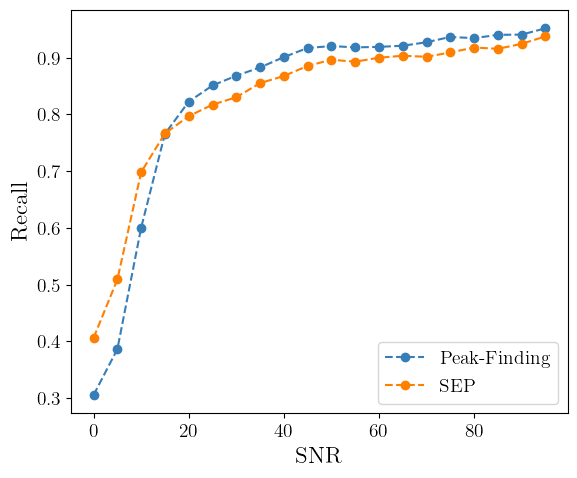

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

mean_recalls_peaks = np.array([recall.aggregate() for recall in recalls_peaks_snr])
mean_recalls_sep = np.array([recall.aggregate() for recall in  recalls_sep_snr])

_x = snr_bins[:-1]

ax.plot(_x, mean_recalls_peaks, '--o', label=r'\rm Peak-Finding', color='C0')
ax.plot(_x, mean_recalls_sep, '--o', label=r'\rm SEP', color='C1')

ax.legend(loc='best')
ax.set_xlabel(r"\rm SNR", fontsize='large')
ax.set_ylabel(r"\rm Recall", fontsize='large')

In [ ]:
# save figure (if desired)
assert Path("figures").exists()
fig.savefig("figures/recall_snr.png", bbox_inches='tight', dpi=500)

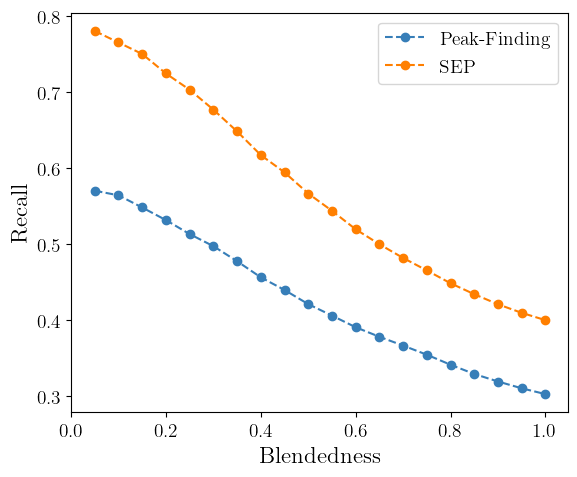

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

mean_recalls_peaks = np.array([recall.aggregate() for recall in recalls_peaks_bld])
mean_recalls_sep = np.array([recall.aggregate() for recall in  recalls_sep_bld])

_x = bld_bins[1:]

ax.plot(_x, mean_recalls_peaks, '--o', label=r'\rm Peak-Finding', color='C0')
ax.plot(_x, mean_recalls_sep, '--o', label=r'\rm SEP', color='C1')

ax.legend(loc='best')
ax.set_xlabel(r"\rm Blendedness", fontsize='large')
ax.set_ylabel(r"\rm Recall", fontsize='large')

ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]);

In [ ]:
# save figure (if desired)
assert Path("figures").exists()
fig.savefig("figures/recall_bld.png", bbox_inches='tight', dpi=500)

In [ ]:
# check precision on all batches at least (doing cut is more difficult than recall)
from btk.metrics.detection import Precision

precision_peaks = Precision(batch_size)
precision_sep = Precision(batch_size)


for _ in tqdm(range(10)):
    blend_batch = next(draw_generator)
    iso_images = blend_batch.isolated_images[:, :, 2] # pick 'r' band


    # run deblenders and matchers
    peak_batch = peak_finder(blend_batch)
    sep_batch = sep(blend_batch)

    matching_peak = matcher(blend_batch.catalog_list, peak_batch.catalog_list)
    matching_sep = matcher(blend_batch.catalog_list, sep_batch.catalog_list)

    precision_peaks(matching_peak.tp, matching_peak.t, matching_peak.p)
    precision_sep(matching_sep.tp, matching_sep.t, matching_sep.p)


100%|██████████| 10/10 [01:03<00:00,  6.38s/it]


In [ ]:
precision_peaks.aggregate(), precision_sep.aggregate()

(0.9881510209012404, 0.9990196078431373)

## Ellipticity residuals for Scarlet 

Here we plot the residual ellipticity errors for the Scarlet deblender as a function of SNR and blendedness. We use the `r`-band images for this comparison, and we condition the deblending on true centroids of each galaxy.

In what follows we setup the Scarlet deblender, the matcher, and the sky level which will be used to compute SNR.

In [ ]:
from surveycodex.utilities import mean_sky_level

# we will continue using 'r' band
sky_level = mean_sky_level(survey, survey.get_filter('r')).to_value('electron') # gain = 1

In [ ]:
from btk.match import PixelHungarianMatcher
from btk.deblend import Scarlet


# use psf size as minimum distance between peaks (in pixels).
min_distance = int(get_psf_size(survey))
scarlet = Scarlet(max_n_sources)
matcher = PixelHungarianMatcher(min_distance)


In [ ]:
from btk.measure import get_ksb_ellipticity, get_blendedness, get_snr
import multiprocessing as mp

njobs = 4 if mp.cpu_count() > 4 else mp.cpu_count() - 1

es1 = []
es2 = []
snrs = []
bs = []

# scarlet is slow, so we use less batches for this example.
for ii in tqdm(range(10)):
    blend_batch = next(draw_generator)
    scarlet_batch = scarlet(blend_batch,
                            reference_catalogs=None, # uses truth catalog
                            njobs=njobs)
    matching_scarlet = matcher(blend_batch.catalog_list, scarlet_batch.catalog_list)

    # need their centroids need to measure ellipticity
    b, ms1, _, _, _ = blend_batch.isolated_images.shape
    centroids1 = np.zeros((b, ms1, 2))
    for jj, t in enumerate(blend_batch.catalog_list):
        n_sources = len(t)
        if n_sources > 0:
            centroids1[jj, :n_sources, 0] = t["x_peak"].value
            centroids1[jj, :n_sources, 1] = t["y_peak"].value

    b, ms2, _, _, _ = scarlet_batch.deblended_images.shape
    centroids2 = np.zeros((b, ms2, 2))
    for kk, t in enumerate(scarlet_batch.catalog_list):
        n_sources = len(t)
        if n_sources > 0:
            centroids2[kk, :n_sources, 0] = t["x_peak"].value
            centroids2[kk, :n_sources, 1] = t["y_peak"].value

    psf_r = blend_batch.psf[2] # psf in r-band

    true_iso_images = blend_batch.isolated_images[:, :, 2] # pick 'r' band
    iso_images_scarlet = scarlet_batch.deblended_images[:, :, 2] # pick 'r' band

    iso_images1, xy1  = matching_scarlet.match_true_arrays(true_iso_images, centroids1)
    iso_images2, xy2 = matching_scarlet.match_pred_arrays(iso_images_scarlet, centroids2)

    ellips1 = get_ksb_ellipticity(iso_images1, xy1, psf_r, pixel_scale=0.2)
    ellips2 = get_ksb_ellipticity(iso_images2, xy2, psf_r, pixel_scale=0.2)

    snr = get_snr(iso_images1, sky_level)
    blendedness = get_blendedness(iso_images1)

    es1.append(ellips1)
    es2.append(ellips2)
    snrs.append(snr)
    bs.append(blendedness)

We now prepare our ellipticity data for plotting, we remove NaNs and include only ellipticities within the physical range i.e. (-1, 1).

In [ ]:
e11 = np.concatenate(es1)[:, :, 0].flatten()
e12 = np.concatenate(es1)[:, :, 1].flatten()
e21= np.concatenate(es2)[:, :, 0].flatten()
e22= np.concatenate(es2)[:, :, 1].flatten()
snr = np.concatenate(snrs).flatten()
bdd = np.concatenate(bs).flatten()

cond1 = ~np.isnan(e11)
cond2 = ~np.isnan(e12)
cond3 = ~np.isnan(e21)
cond4 = ~np.isnan(e22)
cond5 = (snr > 0) & (snr < 100)
cond = cond1 & cond2 & cond3 & cond4 & cond5

e11 = e11[cond]
e12 = e12[cond]
e21 = e21[cond]
e22 = e22[cond]
snr = snr[cond]
bdd = bdd[cond]


Here is the function we will use to plot the residuals of each ellipticity:

In [ ]:
from typing import Tuple
def _scatter_shade_plot(
    ax: plt.Axes,
    x: np.ndarray,
    y: np.ndarray,
    xlims: Tuple[float, float],
    delta: float,
    qs: Tuple[float, float] = (0.25, 0.75),
    color: str = "#377eb8",
    alpha: float = 0.5,
):
    xbins = np.arange(xlims[0], xlims[1], delta)

    xs = np.zeros(len(xbins))
    ys = np.zeros(len(xbins))
    yqs = np.zeros((len(xbins), 2))

    for i, bx in enumerate(xbins):
        keep_x = (x > bx) & (x < bx + delta)
        y_bin: np.ndarray = y[keep_x]

        xs[i] = bx + delta / 2

        if y_bin.shape[0] == 0:
            ys[i] = np.nan
            yqs[i] = (np.nan, np.nan)
            continue

        ys[i] = np.mean(y_bin)
        err = np.std(y_bin) / np.sqrt(len(y_bin))
        yqs[i, :] = np.mean(y_bin) - err, np.mean(y_bin) + err

    ax.plot(xs, ys, marker="o", c=color, linestyle="-")
    ax.fill_between(xs, yqs[:, 0], yqs[:, 1], color=color, alpha=alpha)

Now we plot the mean residuals with the corresponding error as a function of SNR, blendedness, and the true ellipticity: 

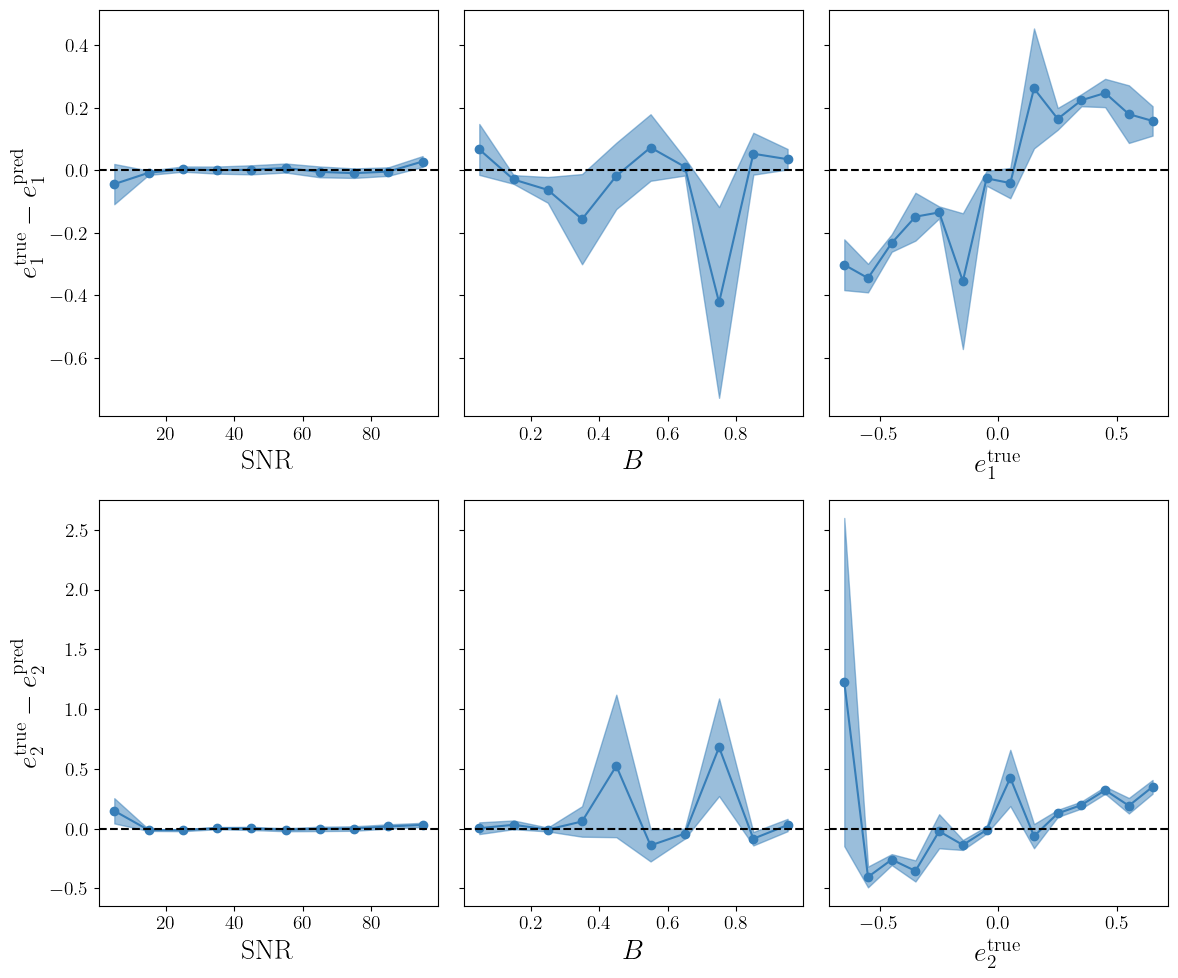

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10), sharey='row')
_scatter_shade_plot(axes[0, 0], snr, e11 - e21, (0, 100), delta=10, alpha=0.5)
_scatter_shade_plot(axes[1, 0], snr, e12 - e22, (0, 100), delta=10, alpha=0.5)
axes[0,0].set_xlabel(r"\rm SNR", fontsize=20)
axes[1, 0].set_xlabel(r"\rm SNR", fontsize=20)
axes[0,0].set_ylabel(r"$e_{1}^{\rm true} - e_{1}^{\rm pred}$", fontsize=20)
axes[1, 0].set_ylabel(r"$e_{2}^{\rm true} - e_{2}^{\rm pred}$", fontsize=20)


_scatter_shade_plot(axes[0, 1], bdd, e11 - e21, (0, 1), delta=0.1, alpha=0.5)
_scatter_shade_plot(axes[1, 1], bdd, e12 - e22, (0, 1), delta=0.1, alpha=0.5)
axes[0,1].set_xlabel(r"$B$", fontsize=20)
axes[1,1].set_xlabel(r"$B$", fontsize=20)


_scatter_shade_plot(axes[0, 2], e11, e11 - e21, (-0.7, 0.7), delta=0.1, alpha=0.5)
_scatter_shade_plot(axes[1, 2], e12, e12 - e22, (-0.7, 0.7), delta=0.1, alpha=0.5)
axes[0, 2].set_xlabel(r"$e_{1}^{\rm true}$", fontsize=20)
axes[1, 2].set_xlabel(r"$e_{2}^{\rm true}$", fontsize=20)

plt.tight_layout()

# set vline at 0 for all plots
for ax in axes.flatten():
    ax.axhline(0, c='k', linestyle='--')


In [ ]:
# save figure (if desired)
assert Path("figures").exists()
assert not Path("figures/ellipticity_residuals.png").exists() # avoid overwritting
fig.savefig("figures/ellipticity_residuals.png", bbox_inches='tight', dpi=500)

# Example blend and reconstruction images (for visualization purposes)

We plot the full blend and then each of the individual galaxies and their reconstructions:

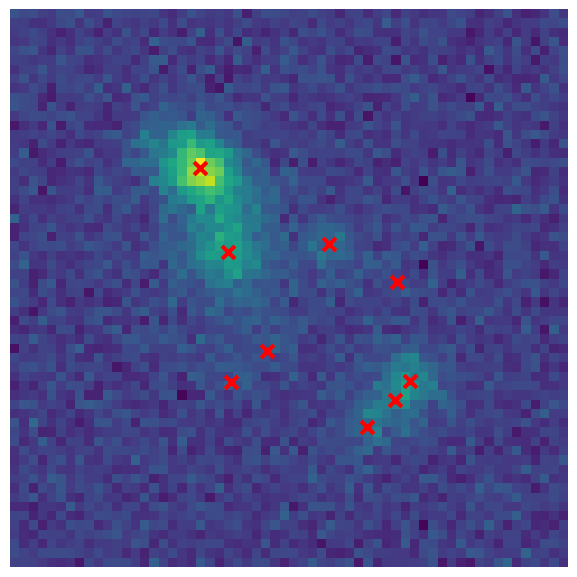

In [ ]:
# pick a random index with a nice looking blend
idx = np.random.randint(0, 100)
fig, ax = plt.subplots(1,1, figsize=(6,6))
crop = 30
im = ax.imshow(blend_batch.blend_images[idx,2, crop:-crop, crop:-crop])
ax.set_axis_off()

x = blend_batch.catalog_list[idx]['x_peak'] - crop
y = blend_batch.catalog_list[idx]['y_peak'] - crop
ax.scatter(x, y, c="r", marker="x", s=85, linewidths=3)

fig.savefig("figures/recon-example1.png", bbox_inches='tight', dpi=500)

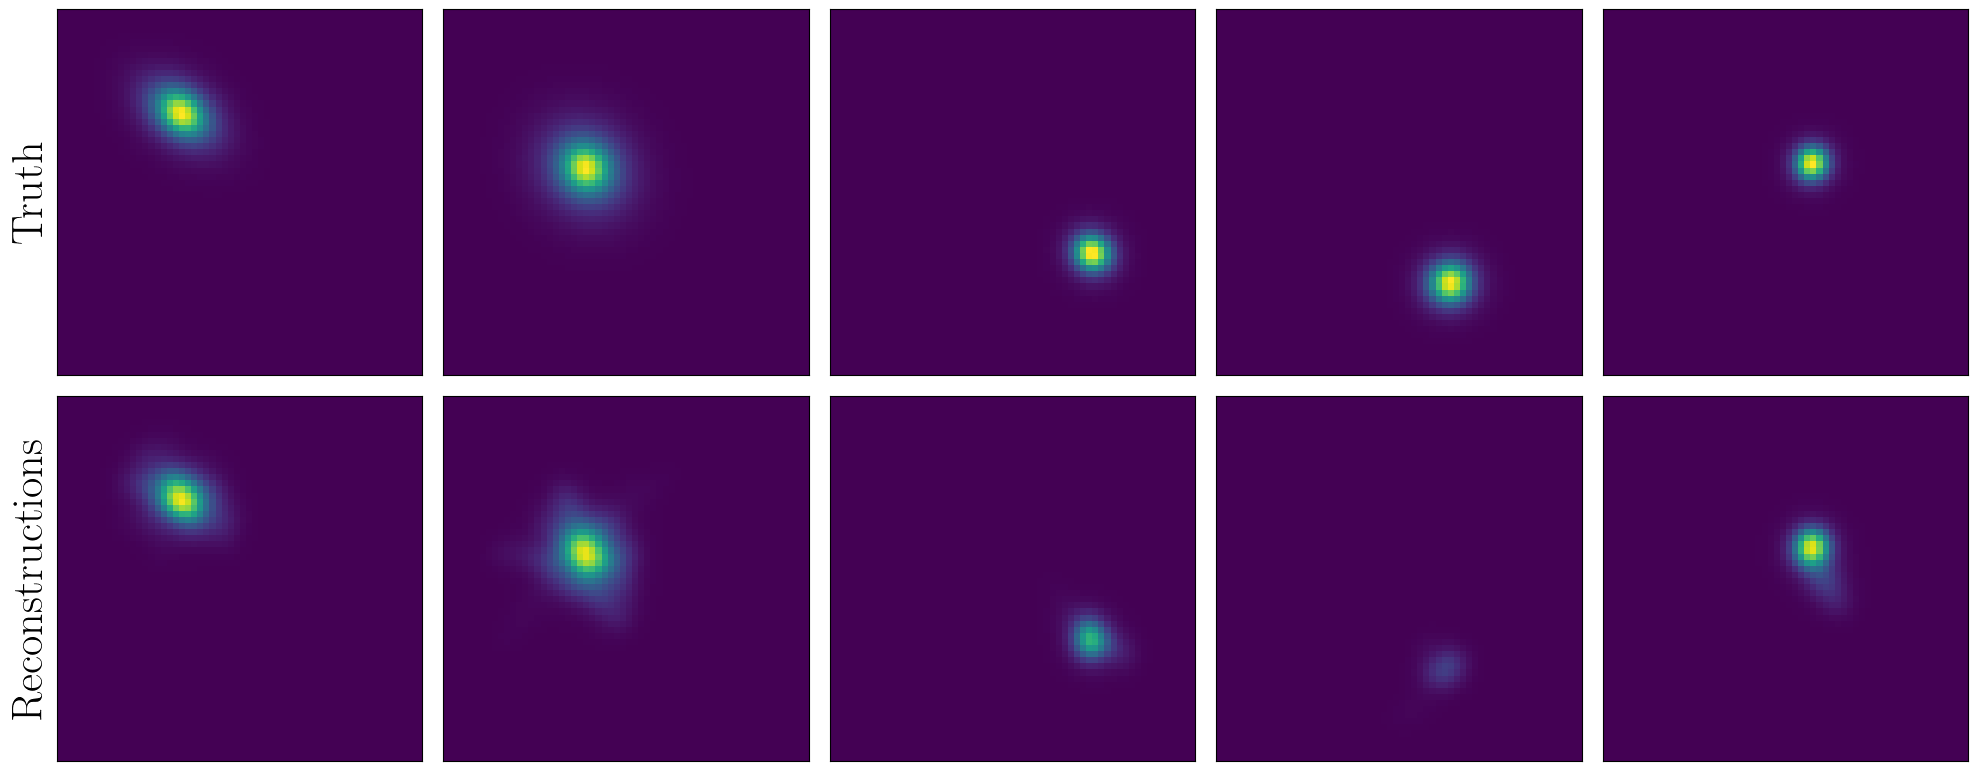

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 8))

order = np.argsort(-np.sum(iso_images1[idx], axis=(-1, -2)))
img1 = iso_images1[idx][order]
img2 = iso_images2[idx][order]

for ii in range(5):
    if ii == 0:
        axes[0, ii].set_ylabel(r"\rm Truth", fontsize=32)
        axes[1, ii].set_ylabel(r"\rm Reconstructions", fontsize=32)
    axes[0,ii].xaxis.set_visible(False)
    axes[0,ii].tick_params(left=False, labelleft=False)
    axes[1,ii].xaxis.set_visible(False)
    axes[1,ii].tick_params(left=False, labelleft=False)

    zmin = min(img1[ii].min(), img2[ii].min())
    zmax = max(img1[ii].max(), img2[ii].max())

    axes[0,ii].imshow(img1[ii][crop:-crop, crop:-crop], vmin=zmin, vmax=zmax)
    axes[1,ii].imshow(img2[ii][crop:-crop, crop:-crop], vmin=zmin, vmax=zmax)


plt.subplots_adjust(hspace=0.25)
plt.tight_layout()
fig.savefig("figures/recon-example2.png", bbox_inches='tight', dpi=500)